In [292]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

PATH = '/home/emastr/phd/projects/martin_housewarming_gift/eagles.jpeg'

def plot_circle(radius, centre, **kwargs):
    plt.gca().add_patch(plt.Circle(centre, radius, **kwargs))
    
   
def plot_circles(points, radius, **kwargs):
    for p in points:
        plot_circle(radius, p, **kwargs)
    

def pack_circles_in_box(box_size, radius, mask=None):
    L = box_size
    dL = radius * 2
    Nx = int(L / dL)
    Ny = int(L / dL * 2 / np.sqrt(3))
    points = []
    for i in range(Nx+1):
        for j in range(Ny+1):
            if mask is not None:
                if mask((i*dL + (j%2)*dL/2, j*dL*np.sqrt(3)/2)):
                    points.append((i*dL + (j%2)*dL/2, j*dL*np.sqrt(3)/2))
            else:
                points.append((i*dL + (j%2)*dL/2, j*dL*np.sqrt(3)/2))
    return points

def extract_pixles(masks, array, extent):
    """Extract pixles inside mask from array"""
    (Ny, Nx, _) = array.shape
    x = np.linspace(extent[0], extent[1], Nx)
    y = np.linspace(extent[2], extent[3], Ny)[::-1]
    X, Y = np.meshgrid(x, y)
    xf, yf = X.flatten(), Y.flatten()
    array_reshape = np.concatenate([array[:, :, i].flatten()[:, None] for i in range(3)], axis=1)/255
    
    masked_pixels = []
    masked_pos_x = []
    masked_pos_y = []
    for mask in masks:
        mask_vals = mask(xf, yf)
        masked_pos_x.append(xf[mask_vals])
        masked_pos_y.append(yf[mask_vals])
        masked_pixels.append(array_reshape[mask_vals, :])
    return masked_pixels, masked_pos_x, masked_pos_y


class Mask:
    def __init__(self, xc, yc, r):
        self.xc = xc
        self.yc = yc
        self.r = r
    def __call__(self, x, y):
        return np.sqrt((x-self.xc)**2 + (y-self.yc)**2) < self.r
        
        
# Color finding function
colors = [np.array([0, 0.28, 0.32]), np.array([1., 1., 1.]), np.array([0.5, 0.5, 0.5]), np.array([0., 0., 0.])]
weights = [0.4, 0.2, 0.4, 0.3]
weights = [w / sum(weights) for w in weights]
def get_color(array, p=2):
    dists = [np.mean(np.sum(np.abs(array - col[None, :])**p)**(1/p))*w for col, w in zip(colors, weights)]
    return colors[np.argmin(dists)], np.argmin(dists)

Text(0.5, 1.0, 'Overlay of packed circles on top of image')

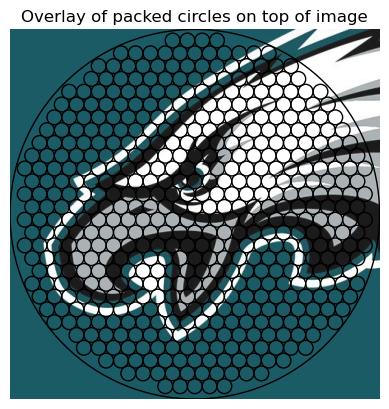

In [307]:
# Pack caps of radius r in a circle of radius 0.5

r = 0.02
mask = lambda x: np.sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2)+r < 0.5
points = pack_circles_in_box(1, r, mask)

# Load an image, make it square by cropping it
im = mpimg.imread(PATH)
#im = im[:1000, 500:-500, :]
im = im[300:800, 500:-800, :]  # Some cropping, this is specific to the image we loaded.
ratio = im.shape[0] / im.shape[1]
Lx = 1/ratio
Ly = 1
extent = [0.5-Lx/2,0.5+Lx/2,0,Ly]


# Plot packed circles on top of image
plt.imshow(im, extent=extent, alpha=0.9)
plot_circles(points, r, fill=False)
plt.gca().add_patch(plt.Circle((0.5,0.5), 0.5, color='k', fill=False))
plt.xlim([0,1])
plt.ylim([0,1])
plt.axis('off')
plt.title("Overlay of packed circles on top of image")

Text(0.5, 1.0, 'Colored caps on top of image')

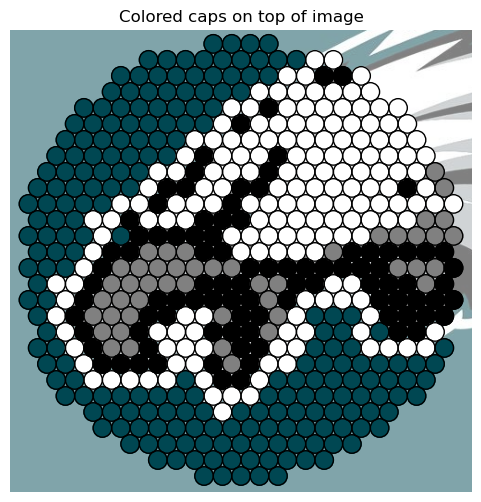

In [310]:
# Find nearest color of all the caps
masks = []
for p in points:
    masks.append(Mask(p[0], p[1], r))
    
pixels, posx, posy = extract_pixles(masks, im, extent)

# Plot the cap colors
plt.figure(figsize=(6, 6))
plt.imshow(im, extent=extent, alpha=0.5)

bars = [0 for i in range(len(colors))]
for patch, pos in zip(pixels, points):
    col, idx = get_color(patch, p=2)
    bars[idx] += 1
    plt.gca().add_patch(plt.Circle(pos, r, color=col))
plot_circles(points, r, fill=False)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.axis('off')
plt.title("Colored caps on top of image")

Text(0, 0.5, 'number of caps')

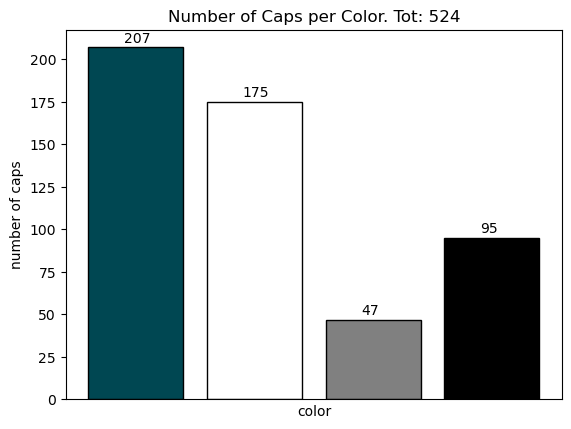

In [313]:
plt.figure()
plt.bar(range(len(colors)), bars, color=colors, edgecolor='k')

plt.title(f"Number of Caps per Color. Tot: {sum(bars)}")
plt.xlabel("color")
plt.xticks([])
for i, b in enumerate(bars):
    plt.text(i-0.1, b+3, str(b))
plt.ylabel("number of caps")